*Note - Due to Twitter's terms of use, the hydrated tweet data cannot be shared. Therefore, this notebook is provided as a PDF in order to share the model training process.*

In [1]:
import sys
import os
import json
import dill
import csv

import pandas as pd
import numpy as np

from pathlib import Path
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

<h1 style="text-alight:center;"><p style="text-align: center;">Learn These Headline-Writing Tips - Before Your Competitors Do!</p> </h1>
<h3  style="text-alight:center;"><p style="text-align: center;"><span style="color:#1DA1F2">Exploring the impact of clickbait on social media interactions for news organizations' tweets</span></p> </h3>
<h4><p style="text-align:center;">Alexander Wood</p></h4>


In the United States, at least 82% of adults get at least some of their news online.This switch to digital media has profoundly shaped news orgs’ business models, and social media taglines are often modified to be controversial, misleading about article contents in order to attract clicks.

This product provides a tool for media organizations to analyze user interaction with Tweets based on a "clickbaitness" score. This tool uses natural language processing to judge the clickbaitiness of a Tweet based on its content.

## [View the project website](http://wood-bait-switch.herokuapp.com/)

This notebook provides an overview of the database creation, data exploration, and model training used to create a "clickbaitiness" classifier. Note that due to Twitter's terms of use, I cannot share 'Hydrated' Tweet data. However, you are welcome to follow along. [Download the tweet IDs](https://github.com/alexanderwood/wood-clickbait/tree/master/data) and hydrate the tweets using:

* [This tweet Hydrator module]((https://github.com/alexanderwood/hydrate-tweets-api-v2)) I wrote for this project. This module allows you to query Twitter's Developer API v2 for comprehensive tweet information in batches of tweet IDs using the [Tweet endpoint](https://developer.twitter.com/en/docs/twitter-api/tweets/lookup/api-reference/get-tweets#requests). Instructions are available in the project's repository - note you will need access to the new(er) Twitter Developer API v2
* [My script for hydrating this dataset](https://github.com/alexanderwood/wood-clickbait/code/hydrate-webis.py) could be adapted for personal use. 

## Training a Classifier

Training a classifier requires some understanding of the "ground truth." While clickbaitiness will always be a matter of opinion,  work has been done to create a consensus-driven dataset of tweets annotated by clickbaitiness. This data, the [Webis Clickbait Corpus 17](https://webis.de/data/webis-clickbait-17.html), provides 38,517 Twitter posts from 27 major US news publishers. Posts were annotated by five annotators on a 4-point scale, where:

* 0.00: Not click baiting
* 0.33: Slightly click baiting
* 0.67: Considerably click baiting
* 1.00: Heavily click baiting

Various methods of evaluating clickbaitiness are provided. For the remainder of this notebook, data is considered clickbait if the average score across annotators is greater than or equal to 0.50. The training dataset is publicly available.

#### Load the data

Let's load the dataset and get started.

In [2]:
# Load data
fpath = Path.cwd().parent / 'data' / 'webis-clickbait-17' 

In [3]:
import json

def load_features():
    '''Load the dataset'''
    
    # MUST SPECIFY DTYPES - PANDAS BUG LARGE NUMERIC STRINGS 
    X = pd.read_csv(fpath /'tweets-clean.csv' , index_col=0,
                   dtype={'tweet_id': str, 
                          'author_id': str, 
                          'name': str, 
                          'username': str, 
                          'timestamp': str, 
                          'retweets': np.int64,
                          'replies': np.int64, 
                          'likes': np.int64, 
                          'quotes': np.int64, 
                          'text': str, 
                          'url': str})
    X[['text']] = X.apply(lambda x: x.text.split('http')[0].rstrip(), axis=1)  # Clean text/remove URLs
    X = X.drop_duplicates(subset='tweet_id', ignore_index=True)  # Drop duplicate IDs.

    return X


def load_targets():
    '''Load the target variables'''
     
    # MUST SPECIFY DTYPES - PANDAS BUG LARGE NUMERIC STRINGS 
    y = pd.read_json(fpath / 'raw-data' / 'truth.jsonl', 
                     lines=True,
                    dtype={'truthJudgments':list, 
                           'truthMean':np.float64, 
                           'id':str, 
                           'truthClass':str, 
                           'truthMedian':np.float64,
                           'truthMode':np.float64})
    y = y.rename(columns={'id':'tweet_id'})

    # Split the judges' scores into their own columns.
    cols = ['score1', 'score2', 'score3', 'score4']
    for i in range(len(cols)):
        y[[cols[i]]] = y[['truthJudgments']].apply(lambda x: x.truthJudgments[i],axis=1)

    return y

def load_data():
    '''Driver code'''
    X = load_features()
    y = load_targets()
    
    # Combined dataframe. 
    df = X.merge(y, left_on='tweet_id', right_on='tweet_id')
    
    return df


df = load_data()


In [4]:
df.head(5)

,tweet_id,author_id,name,username,timestamp,retweets,replies,likes,quotes,text,url,truthJudgments,truthMean,truthClass,truthMedian,truthMode,score1,score2,score3,score4
0,858462320779026433,16973333,The Independent,Independent,2017-04-29T23:25:41.000Z,29,1,9,3,UK’s response to modern slavery leaving victim...,https://t.co/1lO8GUCiOC,"[0.33333333330000003, 0.0, 0.33333333330000003...",0.133333,no-clickbait,0.000000,0.000000,0.333333,0.000000,0.333333,0.0
1,858421020331560960,457984599,Breitbart News,BreitbartNews,2017-04-29T20:41:34.000Z,94,16,285,2,this is good,https://www.breitbart.com/politics/2017/04/28/...,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,clickbait,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,858368123753435136,2467791,The Washington Post,washingtonpost,2017-04-29T17:11:23.000Z,130,33,237,11,"The ""forgotten"" Trump roast: Relive his brutal...",https://www.washingtonpost.com/news/arts-and-e...,"[0.33333333330000003, 1.0, 0.33333333330000003...",0.466667,no-clickbait,0.333333,0.333333,0.333333,1.000000,0.333333,0.0
3,858323428260139008,191768572,Indiatimes,indiatimes,2017-04-29T14:13:46.000Z,1,0,1,0,Meet the happiest #dog in the world!,https://t.co/XSdyX0bfoL,"[1.0, 0.6666666666000001, 1.0, 1.0, 1.0]",0.933333,clickbait,1.000000,1.000000,1.000000,0.666667,1.000000,1.0
4,858283602626347008,15438913,Daily Mail Online,MailOnline,2017-04-29T11:35:31.000Z,120,8,47,14,Tokyo's subway is shut down amid fears over an...,https://t.co/zWnqbaE68o,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,no-clickbait,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


#### Data Exploration

We have $19,503$ tweets annotated by four different annotators. Let's look at how 'clickbaity' the data is within the dataset.

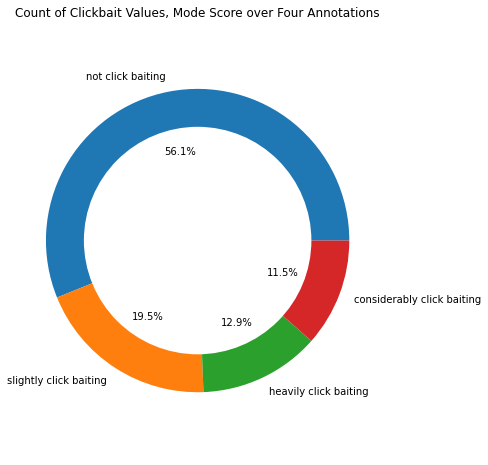

In [5]:
def plot_ring(col, title, labels):
    
    sizes = df[col].value_counts()
    colors = ['#ff99aa','#66b3ff','#99ff99','#ffcc22']

    # print(sizes) # adds up to 1433, which is the total number of participants
    fig1, ax1 = plt.subplots()
    fig1.set_figheight(8)
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
    ax1.axis('equal')

    # Plot circle.
    centre_circle = plt.Circle((0,0), 0.75, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.title(title)
    plt.show()
    
    
score_name = 'Mode'
title = "Count of Clickbait Values, {} Score over Four Annotations".format(score_name)
labels = ['not click baiting', 'slightly click baiting', 'heavily click baiting', 'considerably click baiting']  
plot_ring('truthMode', title, labels)

A bit over half the posts are considered not clickbait at all. Only $11.5%$ is considered heavily clickbaiting. We see already there will be some level of imbalance in the dataset. Let's look at the binary classifications of the data.

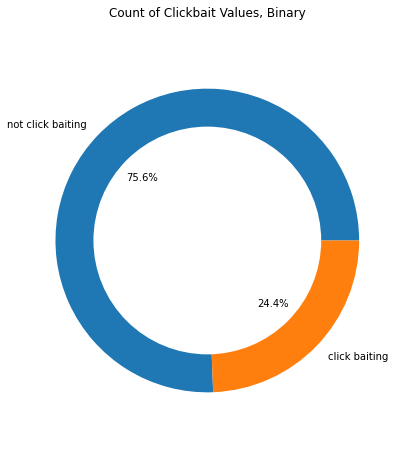

In [6]:
title = "Count of Clickbait Values, Binary"
labels = ['not click baiting', 'click baiting']  

plot_ring('truthClass', title, labels)

As predicted, the dataset is imbalanced with only about a quarter of the data considered to be clickbait.

## Model Training 

Each model takes as input the text of the tweet and returns a classification as clickbait or not clickbait. Let's start with viewing this as a binary classification problem. The binary classifications are given in the `truthClass` column, with values `no-clickbait` or `clickbait`. The text is in the `text` column. 

We are going to take a quarter of the data and set it aside as the holdout test set. 

In [7]:
from sklearn.model_selection import train_test_split

X, X_val, y, y_val = train_test_split(df[['text']], df[['truthClass']], 
                                      test_size = 0.25,
                                      shuffle=True,
                                      stratify=df[['truthClass']],
                                      random_state=420)


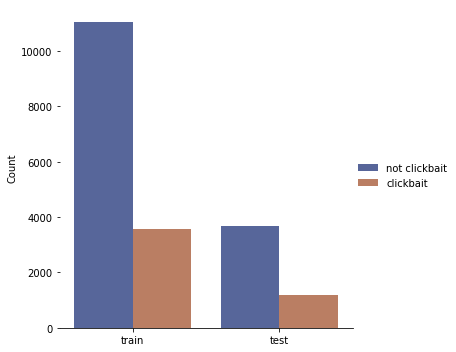

In [8]:
# Draw a nested barplot by count of each target variable in train and test sets
dat = pd.DataFrame([
    ['train', y.value_counts()[0], 'not clickbait'], 
    ['train', y.value_counts()[1], 'clickbait'],
    ['test', y_val.value_counts()[0], 'not clickbait'],
    ['test', y_val.value_counts()[1], 'clickbait']],
    columns=['Set', 'Count', 'Clickbait Value']
)


g = sns.catplot(
    data=dat, kind="bar",
    x="Set", y="Count", 
    hue="Clickbait Value",
    palette="dark", alpha=.7, height=5,
    ci=None
)

g.despine(left=True)
g.set_axis_labels("", "Count")
g.legend.set_title("")

As we can see, the ratio of clickbait to non-clickbait is about equal in the test and train sets. However, the data is class imbalanced. We will need to keep a careful eye on this during model training. 

In [9]:
# Positive label: clickbait
y = (y.values == 'clickbait').ravel().astype(np.int16)
y_val = (y_val.values == 'clickbait').ravel().astype(np.int16)

### Feature Extraction

To train a model, we need to extract features. We use some Natural Language Processing (NLP) techniques for "vectorizing" text into machine learning-friendly features. In particular, we try out count-based vectorization and a classic technique called Tf-Idf. 

The next few cells define functions we will use to build model pipelines and quickly generate data vizualizations to evaluate model performance. 

In [10]:
from sklearn import base

from sklearn.metrics import (classification_report, make_scorer, 
                             accuracy_score, confusion_matrix,
                             plot_confusion_matrix)

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV

In [11]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    '''
    Returns an array containing the selected keys of a feature matrix.
    '''
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        tmp = X[self.col_names].values
        return [t[0] for t in tmp]
   


In [12]:
def display_confusion(classifier, X, y, fname='output.svg'):
    '''
    Tool for displaying side-by-side confusion matrix / normalized confusion matrix for 
    a classifier and testing data. 
    '''
    titles_options = [("Confusion matrix", None, 1),
                      ("Normalized Confusion Matrix", 'true', 2)]
    
    fig = plt.figure(1)
    
    fig.set_figwidth(15)
    for title, normalize, i in titles_options:
        ax = plt.subplot(1,2,i)
        disp = plot_confusion_matrix(classifier, X, y,
                                     display_labels=['Not Clickbait','Clickbait'],
                                     cmap=plt.cm.BuGn,
                                     normalize=normalize,
                                     ax=ax
                                    )
        disp.ax_.set_title(title)
    fig.tight_layout()
    
    plt.show()   

        
def save_confusion(classifier, X, y, fdir):
    '''
    Tool for displaying side-by-side confusion matrix / normalized confusion matrix for 
    a classifier and testing data. 
    '''
    titles_options = [("Confusion matrix", None, 1, 'confmat.svg'),
                      ("Normalized Confusion Matrix", 'true', 2, 'confmat-norm.svg')]
    titles=['confmat.svg', 'confmat-norm.svg']
    
    for title, normalize, i, fname in titles_options:
        fig = plt.figure(1)
        fig.set_figwidth(15)
        disp = plot_confusion_matrix(classifier, X, y,
                                     display_labels=['Not Clickbait','Clickbait'],
                                     cmap=plt.cm.BuGn,
                                     normalize=normalize)
        disp.ax_.set_title(title)
        fig.tight_layout()
        plt.savefig(fdir / fname)

        
def cv_report(pipe):
    '''Display cross-validation reports for a sklearn pipeline'''
    
    strout = "Best parameters:\n{}\n\nGrid Scores:"
    print(strout.format(pipe.best_params_))
    means = pipe.cv_results_['mean_test_score']
    stds = pipe.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, pipe.cv_results_['params']):
        print("{0:.3f} (+/-{1:.03f}) for {2!s}".format(mean, std * 2, params))

Let's put together a bare-bones Bare-bones stopword list comprised of the most common non-proper-noun words in the training corpus.

In [13]:
stopwords = ['the', 'to', 'in', 'of', 'for', 'and', 'is', 'on', 'an', 'a'] 

Let's move on to training a model.

### Model Selection

We start with a simple, linear model, without fussing over normalizing or cleaning the data. This will be our benchmark model. Let's also set some debug options. 

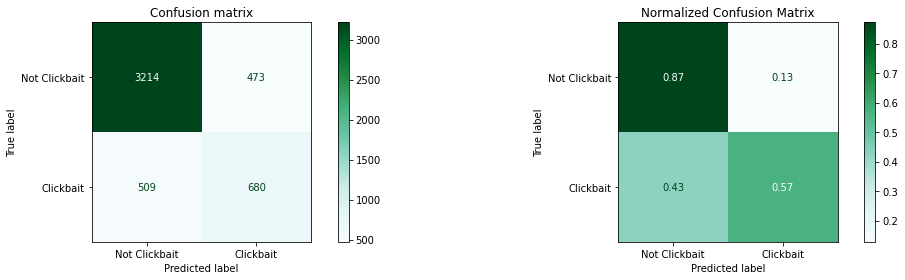

In [14]:
DEBUG = True  # Always retrain in debug mode
fname = Path.cwd().parent / 'assets' / 'models' / 'clf-counts.pkl'
scoring = {'f1': 'f1', 'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

if not DEBUG and os.path.exists(fname):
    with open(fname, "rb") as f:
        clf_counts = dill.load(f)
else:
    param_grid = [{'alpha':[0.0001, 0.001, 0.005, 0.01]}]
    gridcv = GridSearchCV(SGDClassifier(), param_grid, cv=10, scoring=scoring, refit='f1')
    clf_counts = Pipeline([
        ('transformer', ColumnSelectTransformer(['text'])),
        ("vectorizer", CountVectorizer()), # Vectorizer
        ("classifier", gridcv)# Regressor
    ])
    clf_counts.fit(X, y)
    
    if not DEBUG:
        with open(fname, "wb") as f:
            dill.dump(clf_cxounts, f)
    
    
display_confusion(clf_counts, X_val, y_val)

If we look at the normalized confusion matrix, we see quite clearly that this model is having a hard time correctly classifying clickbait - there is a high false negative rate. 

We would like to introduce some complexity to our model, as we are underfitting the data at present. There are multiple methods to do this:

1. Use $n$-grams for $n>1$.
2. Normalized vectorizer (eg, `Tfidf`)
3. Classifiers that account for class imbalance. 

For the next model, let's try a Logistic Regression model. We will use the `sag` solver for speed, and once again fit to F1-score rather than accuracy due to class imbalance. 

In [15]:
# Train (or load) model. 
from sklearn.linear_model import LogisticRegression

DEBUG = False
fname = Path.cwd().parent / 'assets' / 'models' / 'clf-logreg.pkl'
scoring = {'f1': 'f1', 'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

if not DEBUG and os.path.exists(fname):
    with open(fname, "rb") as f:
        clf_logreg = dill.load(f)
else:
    param_grid = [{'solver':['sag'], 'class_weight':['balanced'], 'tol':[0.001, 0.0001, 0.00001]}]
    gridcv = GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring=scoring, refit='f1')
    clf_logreg = Pipeline([
        ('transformer', ColumnSelectTransformer(['text'])),
        ("vectorizer", TfidfVectorizer(ngram_range=(1,2,3), stop_words=stopwords)), # Vectorizer
        ("classifier", gridcv)# Regressor
    ])
    clf_logreg.fit(X, y)
    
    if not DEBUG:
        with open(fname, "wb") as f:
            dill.dump(clf_logreg, f)
    
    

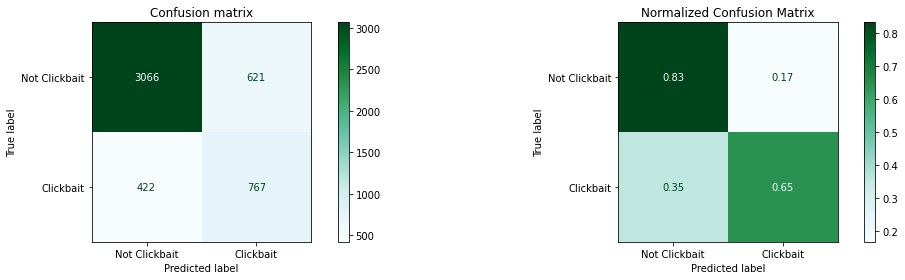

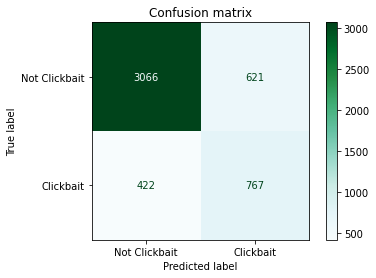

<Figure size 1080x288 with 0 Axes>

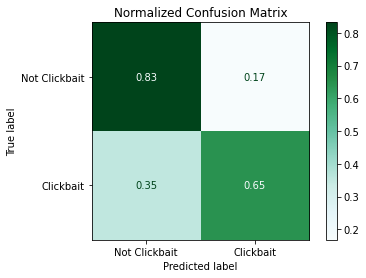

In [16]:
display_confusion(clf_logreg, X_val, y_val, 'confusion.svg')

fdir = Path.cwd().parent / 'assets' / 'img' / 'svg'
save_confusion(clf_logreg, X_val, y_val, fdir)

We get the best results when we use up to 3-grams. 

In [17]:
y_pred = clf_logreg.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      3687
           1       0.55      0.65      0.60      1189

    accuracy                           0.79      4876
   macro avg       0.72      0.74      0.72      4876
weighted avg       0.80      0.79      0.79      4876



We have an F1-score of 0.86 and an accuracy of 0.79. This is a good start, and in fact is has a F1-score than the baseline during the [Clickbait Challenge 2017](https://arxiv.org/abs/1812.10847), suggesting this has a better of handling the class imbalance. 

## Creating a dataset

Now that we have a classifier, we want to see how different news organizations compare to each other regarding clickbaitiness levels. To do this, I created a dataset by gathering [all Tweet IDs for posts in 2017]() for 13 different news organizations. I used the [Twitter API V2](https://developer.twitter.com/en/products/twitter-api) to hydrate the tweets.

The Tweet IDs are available [here](https://github.com/alexanderwood/wood-clickbait/tree/master/data/tweets/tweet-ids). Tweet IDs were chosen based on the following criteria:

* Posted during the calendar year of 2017
* Original post (e.g. not a retweet)
* Contains at least one URL

Data was hydrated via the Twitter API and structured as a .csv dataset via scripts available [here](https://github.com/alexanderwood/wood-clickbait/tree/master/code).

## Analyzing the dataset

Next, let's analyze the data from the 13 selected news organizations in order to analyze trends. 

In [18]:
orgs = ['abc', 'bbc', 'breitbart', 'cbs', 'cnn', 'fox', 'huffpo', 'msnbc', 'nbc', 'npr', 'nytimes', 'wapo', 'wsj']

In [19]:
def load_tweetset(org_handle):
    '''Load the dataset'''
    
    # MUST SPECIFY DTYPES - PANDAS BUG LARGE NUMERIC STRINGS 
    X = pd.read_csv(Path.cwd().parent / 'data' / 'tweets' / 'tweet-hydrated' / '{}-2017.csv'.format(org_handle), index_col=None,
                   dtype={'tweet_id': str,
                          'author_id': str,
                          'name': str,
                          'username': str,
                          'timestamp': str,
                          'retweets': np.int64,
                          'replies': np.int64,
                          'likes': np.int64,
                          'quote_count': np.int64,
                          'text': str,
                          'url': str})

    print(org_handle+ '\t\t', X.shape, end="\t")
    X[['text']] = X.apply(lambda x: x.text.split('http')[0].rstrip(), axis=1)  # Clean text/remove URLs
    X = X.drop_duplicates(subset='tweet_id', ignore_index=True)  # Drop duplicate IDs.
    print(X.shape)
    return X


In [20]:
# Predict clickbaitiness score for each of the news orgs. 
scores_prob = pd.DataFrame(columns=['tweet_id', 'author_id', 'author_name', 'author_handle', 'created_at', 'retweet_count', 'reply_count', 'like_count', 'quote_count', 'text', 'url']+['bait_proba', 'nonbait_proba'])
print('Handle', '# Tweets', '# Valid Tweets', sep='\t\t')
for org in orgs:
    df = load_tweetset(org)
    data_pred = clf_logreg.predict_proba(df)
    df['bait_proba'] = [d[1] for d in data_pred]
    df['nonbait_proba'] = [d[0] for d in data_pred]
    df['scores'] = ['clickbait' if d[1] >= 0.5 else 'non-clickbait' for d in data_pred]
    scores_prob = scores_prob.append(df)

scores_prob.head()

Handle		# Tweets		# Valid Tweets
abc		 (31083, 11)	(31083, 11)
bbc		 (12651, 11)	(12651, 11)
breitbart		 (6878, 11)	(6878, 11)
cbs		 (34263, 11)	(34263, 11)
cnn		 (47796, 11)	(47796, 11)
fox		 (36566, 11)	(36566, 11)
huffpo		 (14125, 11)	(10025, 11)
msnbc		 (10269, 11)	(10269, 11)
nbc		 (9431, 11)	(9431, 11)
npr		 (7812, 11)	(7812, 11)
nytimes		 (36946, 11)	(36946, 11)
wapo		 (45349, 11)	(45349, 11)
wsj		 (43272, 11)	(43272, 11)


,tweet_id,author_id,author_name,author_handle,created_at,retweet_count,reply_count,like_count,quote_count,text,url,bait_proba,nonbait_proba,scores
0,888023039576879104,28785486,ABC News,ABC,2017-07-20T13:09:25.000Z,34,9,29,11,O.J. Simpson is set to face a Nevada parole bo...,https://t.co/2tEOLfJ2CK,0.233541,0.766459,non-clickbait
1,887959662573887488,28785486,ABC News,ABC,2017-07-20T08:57:35.000Z,21,30,38,9,Pres. Trump issues statement on McCain's brain...,https://t.co/JkClGl19MM,0.159754,0.840246,non-clickbait
2,887920778892660736,28785486,ABC News,ABC,2017-07-20T06:23:05.000Z,346,29,978,32,Stunning video captures a young whale 'dancing...,https://t.co/O0pXTKVqV6,0.436111,0.563889,non-clickbait
3,887912731742949377,28785486,ABC News,ABC,2017-07-20T05:51:06.000Z,353,248,303,128,Utility worker's cellphone video shows South F...,https://t.co/O0pXTKVqV6,0.108897,0.891103,non-clickbait
4,887822026739781632,28785486,ABC News,ABC,2017-07-19T23:50:40.000Z,70,9,79,11,Minnesota teen who ran away from home in 1976 ...,https://t.co/kUDijG2FIi,0.252621,0.747379,non-clickbait


In [21]:
scores_prob[scores_prob.author_handle=='nytimes'].head()

,tweet_id,author_id,author_name,author_handle,created_at,retweet_count,reply_count,like_count,quote_count,text,url,bait_proba,nonbait_proba,scores
0,882207618890166273,807095,The New York Times,nytimes,2017-07-04T12:01:01.000Z,45,13,158,14,"A break-neck backstage tour of the Met Opera, ...",https://t.co/N7UTHKIJs7,0.225993,0.774007,non-clickbait
1,882132782184620032,807095,The New York Times,nytimes,2017-07-04T07:03:39.000Z,165,64,163,39,North Korea Says It Has Successfully Tested ICBM,https://t.co/Tp5Fq1tV48,0.060109,0.939891,non-clickbait
2,882096325403320320,807095,The New York Times,nytimes,2017-07-04T04:38:47.000Z,74,55,144,10,Tehran Journal: Why Are These Iranians ‘Really...,https://t.co/suPuiTvyjn,0.822935,0.177065,clickbait
3,882064225543303169,807095,The New York Times,nytimes,2017-07-04T02:31:13.000Z,152,106,227,45,Breaking News: Gov. Chris Christie and the New...,https://t.co/KXgPwELnwl,0.255252,0.744748,non-clickbait
4,881942637372166144,807095,The New York Times,nytimes,2017-07-03T18:28:05.000Z,63,12,155,13,"What do Ohio State, Williams College and Loyol...",https://t.co/iZc9VAoFFq,0.560583,0.439417,clickbait


Great! Now that we've downloaded the data, let's compare the rate of clickbait posts across news organizations. 

In [22]:
scores = scores_prob[['author_name', 'author_handle', 'scores']].value_counts().sort_index().unstack(level=2)
scores.head(13)

,scores,clickbait,non-clickbait
author_name,author_handle,,
ABC News,ABC,2444,28639
BBC News (World),BBCWorld,1264,11387
Breitbart News,BreitbartNews,3751,3127
CBS News,CBSNews,3770,30493
CNN,CNN,9086,38710
Fox News,FoxNews,5276,31290
HuffPost,HuffPost,2174,7851
MSNBC,MSNBC,1334,8935
NBC News,NBCNews,1580,7851


Let's visualize this information.

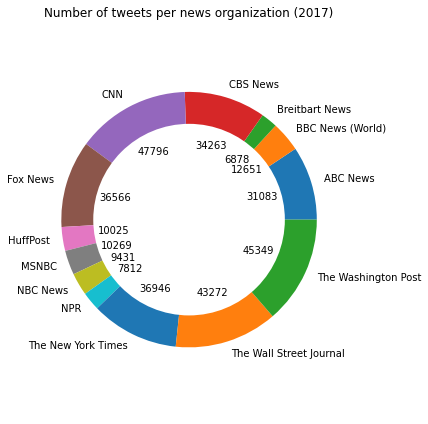

In [23]:
def plot_ring(title, labels, heights, fdir):
    def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{v:d}'.format(v=val)
        return my_format

    N = 2
    #colors = ['#ff99aa','#66b3ff','#99ff99','#ffcc22']
    # print(sizes) # adds up to 1433, which is the total number of participants
    fig1, ax1 = plt.subplots()
    fig1.set_figheight(6)
    ax1.pie(heights, labels=labels, autopct=autopct_format(heights))
    ax1.axis('equal')

    # Plot circle.
    centre_circle = plt.Circle((0,0), 0.75, fc='#FFFFFF')#'#F0F9F1')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.title(title)
    plt.tight_layout()
    plt.savefig(fdir / "tweet-count-by-org.svg")
    plt.show()

    
full_names = [f[0] for f in scores.index.values.tolist()]
num_tweets_by_org = scores_prob.author_name.value_counts().sort_index().to_numpy()
score_name = 'Mode'
title = "Number of tweets per news organization (2017)".format(score_name)

fdir = Path.cwd().parent / 'assets' / 'img' / 'svg'
plot_ring(title, full_names, num_tweets_by_org, fdir)

with open(Path.cwd().parent / 'assets' / 'csv' / "tweet_count_by_org.csv", "w") as f:
    w = csv.writer(f)
    w.writerow(full_names)
    w.writerow(num_tweets_by_org)

Some organizations tweet more often than others, unsurprisingly. As for clickbait frequency, let's continue.

In [24]:
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, FactorRange, HoverTool
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.resources import INLINE

In [25]:
percent_bait_by_org = (scores['clickbait'] / num_tweets_by_org).tolist()
percent_nonbait_by_org = (-1 * scores['non-clickbait'] / num_tweets_by_org).tolist()
cds_bait = ColumnDataSource(data=dict(names=full_names, vals=percent_bait_by_org))
cds_nonbait = ColumnDataSource(data=dict(names=full_names, vals=percent_nonbait_by_org))

In [26]:
# Bokeh plot
output_notebook(INLINE)

# Create the figure
p = figure(
    y_range=full_names, 
    plot_height=350, 
    x_range=(-1, 1), 
    title="Percentage of clickbait & non-clickbait Posts by organization",
    toolbar_location=None)

lbl = ['clickbait', 'non-clickbait']
p.hbar_stack(['vals'], y='names', height=0.9, color='#243447', source=cds_nonbait,
             legend_label=['Non-Clickbait'])
p.hbar_stack(['vals'], y='names', height=0.9, color='#FDAC53', source=cds_bait,
             legend_label=['Clickbait'])
p.y_range.range_padding = 0.1
p.xgrid.grid_line_color, p.ygrid.grid_line_color = None, None
p.axis.major_tick_line_color, p.axis.minor_tick_line_color = None, None
p.legend.location = "top_right"
p.axis.axis_line_color=None
p.outline_line_color = None
p.xaxis.ticker = []
p.title.text_color="#141D26"
p.yaxis.axis_label_text_color = "#141D26"

show(p)

Loading BokehJS ...

In [27]:
import csv
fdir = Path.cwd().parent / 'assets' / 'csv'
with open(fdir / "perc_by_org.csv", 'w') as f:
    writer = csv.writer(f)
    writer.writerow([f[0] for f in full_names])
    writer.writerow(percent_nonbait_by_org)
    writer.writerow(percent_bait_by_org)
    
total_values = scores.to_numpy().transpose()
with open(fdir / "count_by_org.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow([f[1] for f in full_names])
    writer.writerows(total_values)

## Putting it all together

Let's summarize what we have done.

* Identified a business objective
* Trained a classification model for clickbaitiness ranking using NLP and cross-validation
* Created a structured dataset of all tweets from 13 major news organizations from the year 2017
* Classified the data

What we really want to do is analyze the data. For this, I have created an interactive dashboard app with a demo for each news organization. This dashboard was created with Javascript and is available [at the project website](http://wood-bait-switch.herokuapp.com).



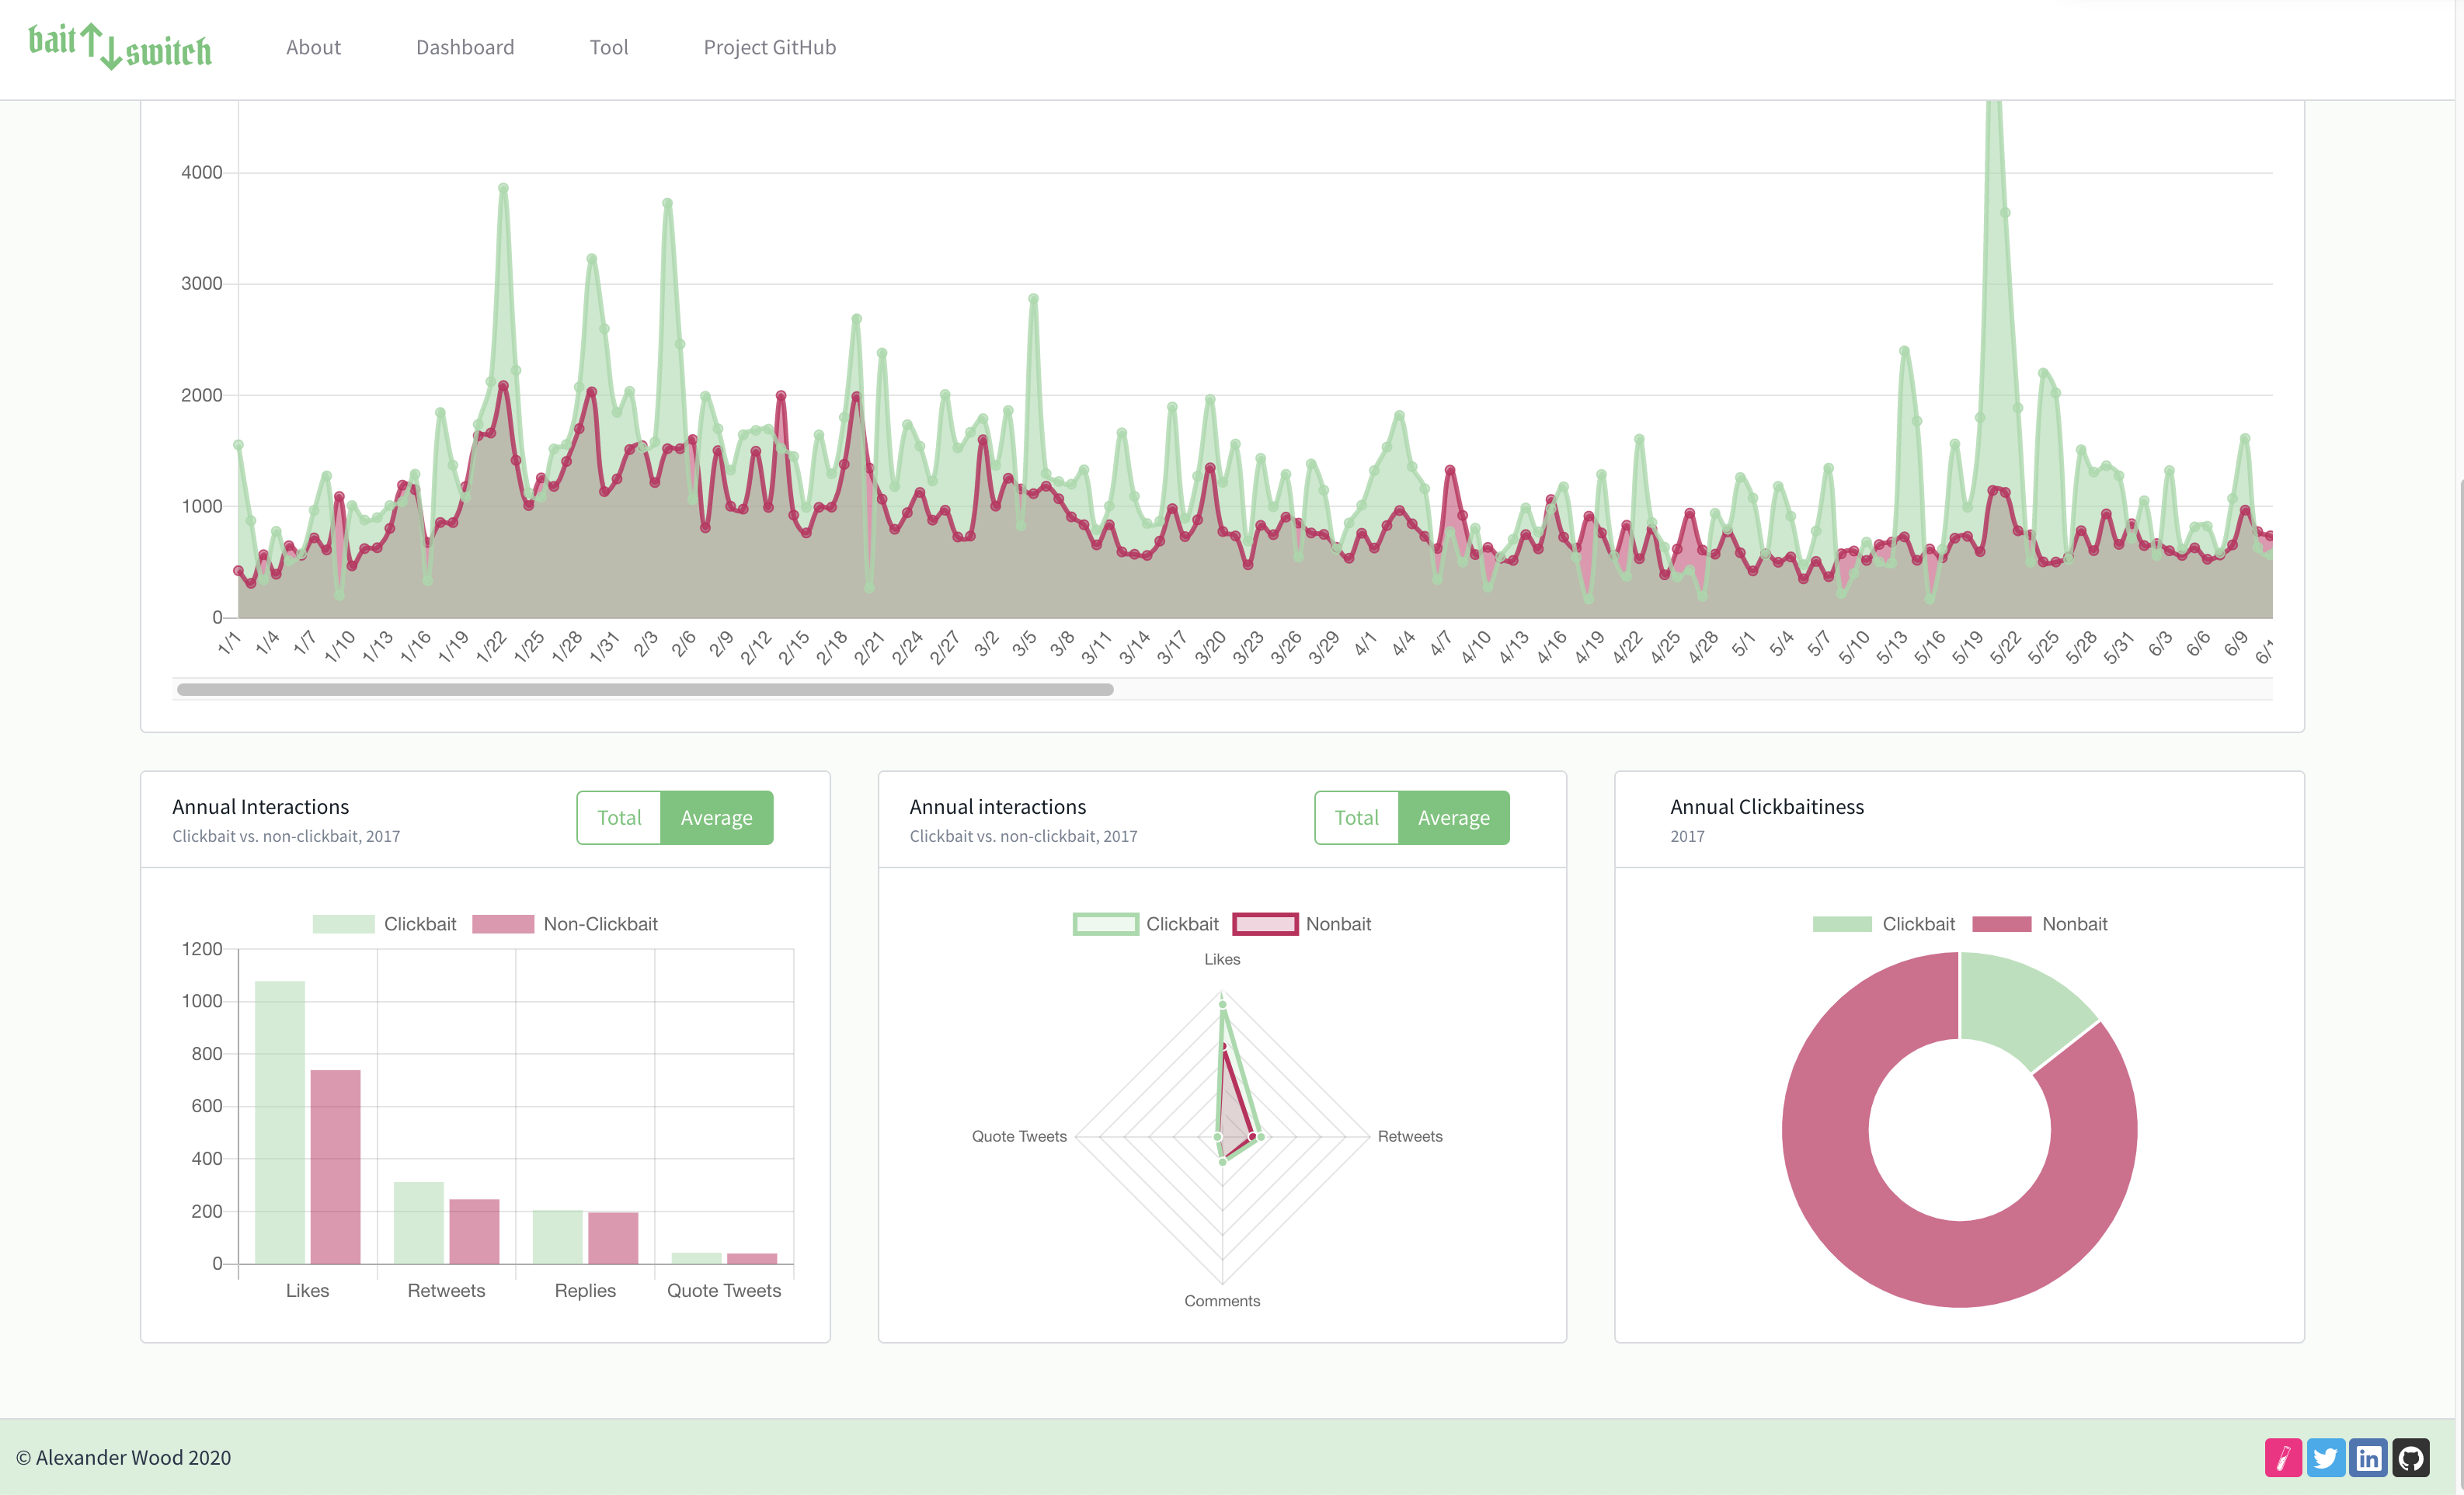